# <b>Training A Face Emotion Detector<b/>

In [ ]:
# importing libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers,applications
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D 

In [ ]:
#getting all the directories

train_dir= r"D:\ALMABETTER\CAPSTONE 5 - FACIAL RECOGNITION SOFTWARE\train"

val_dir= r"D:\ALMABETTER\CAPSTONE 5 - FACIAL RECOGNITION SOFTWARE\validation"

test_dir= r"D:\ALMABETTER\CAPSTONE 5 - FACIAL RECOGNITION SOFTWARE\test"

# **EDA**

First we'll do an image count for validation and train dataset.

In [ ]:
# lsit of all emotions
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
#coounting all the emotions in train and validation set
def count_exp(path, set_):
    dict_ = {}
    for expression in emotions:
        dir_ = os.path.join(path, expression)
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(val_dir, 'test')


In [ ]:
#count for train data set
train_count

,angry,disgust,fear,happy,neutral,sad,surprise
train,4545,1042,4260,7201,4965,5344,3171


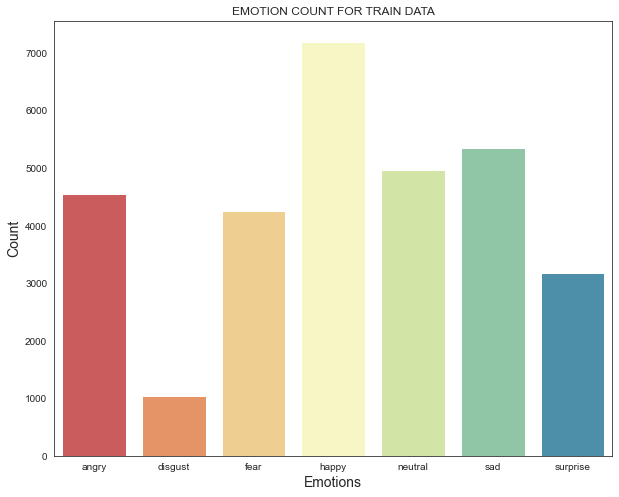

In [ ]:
#plotting emotion count for train data
sns.set_style("white")
plt.figure(figsize= (10,8))
sns.barplot(data=train_count, palette = 'Spectral')
plt.xlabel("Emotions", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.title("EMOTION COUNT FOR TRAIN DATA")
plt.show()

In [ ]:
#count for validation data set
test_count

,angry,disgust,fear,happy,neutral,sad,surprise
test,958,166,1024,1772,1233,1248,831


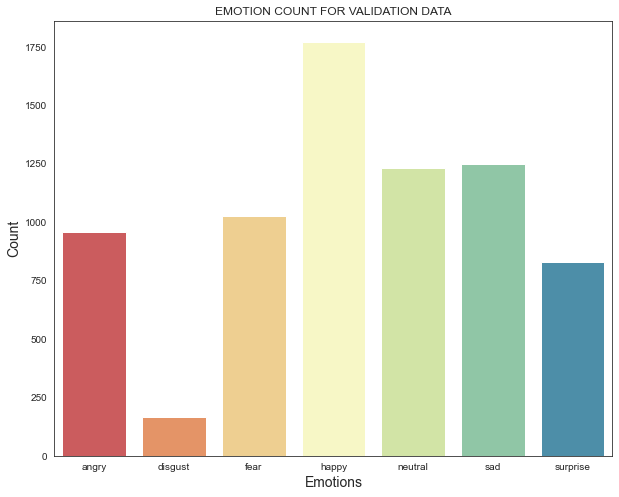

In [ ]:
#plotting emotion count for validation data
plt.figure(figsize= (10,8))
sns.barplot(data=test_count, palette = 'Spectral')
plt.xlabel("Emotions", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.title("EMOTION COUNT FOR VALIDATION DATA")
plt.show()

Let's take a look at some of the images for each emotion nad check if the labels are correct.

In [ ]:
#function to plot images for all emotions

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

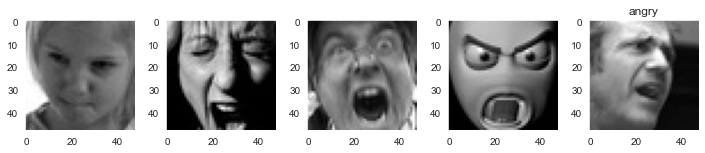

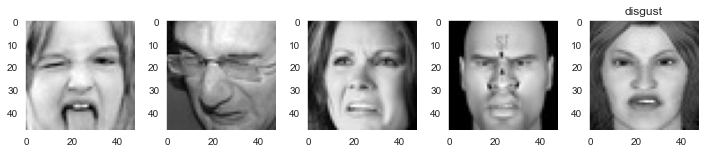

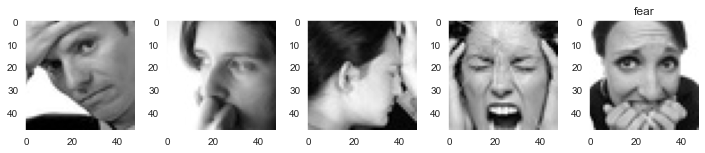

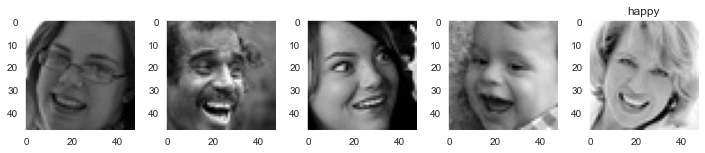

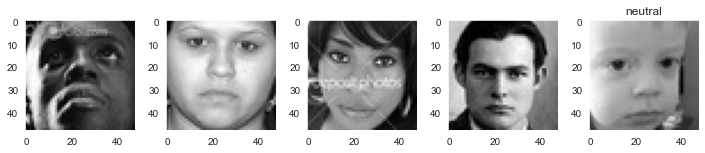

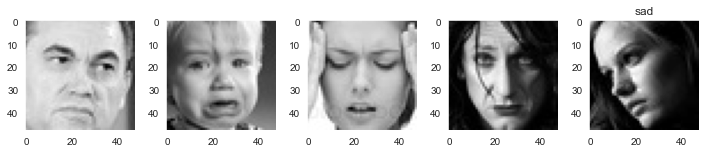

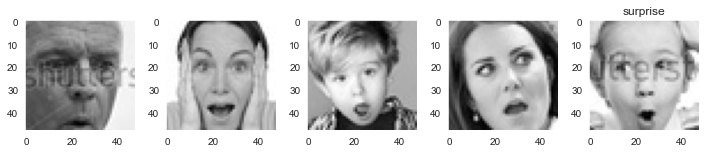

In [ ]:
#plotting images for each class
for emotion in emotions: 
    plot_images(os.path.join(train_dir, emotion))
    plt.title(emotion)


# **DATA PROCESSING**

DATA AUGMENTATION

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.
You can apply any random transformations on each training image as it is passed to the model. This will not only make your model robust but will also save up on the overhead memory.
ImageDataGenerator class ensures that the model receives new variations of the images at each epoch.

In [ ]:
#Defining the augmentation parameters

'''
rotation_range:      rotates the image with the amount of degrees we provide
width_shift_range:   shifts the image randomly to the right or left along the width of the image
height_shift range:  shifts image randomly to up or down along the height of the image
horizontal_flip:     flips the image horizontally
rescale:             to scale down the pixel values in our image between 0 and 1
zoom_range:          applies random zoom to our image
brightness_range:    randomly changes the brightness of the image
'''


train_set = ImageDataGenerator(          rotation_range = 20,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         zoom_range = 0.1,
                                         brightness_range=[0.7,1.3] )

val_set = ImageDataGenerator( rescale = 1./255 )

test_set = ImageDataGenerator( rescale = 1./255 )

In [ ]:
#applying augmentation on our datasets
''' 
target_size:   Size of the input image.
color_mode:    Set to rgb for 3 images with 3 channels and grayscale 1 channel.
batch_size:    Size of each batch in which data will be passed.
class_mode:    Set to binary for only two label classification and categorical for multilabel classification
'''

train_data = train_set.flow_from_directory(directory = train_dir,
                                                    target_size = (48,48),
                                                    batch_size = 32,
                                                    color_mode ='grayscale',
                                                    class_mode = "categorical"
                                                   )
val_data = test_set.flow_from_directory( directory = val_dir,
                                                              target_size = (48,48),
                                                              batch_size = 32,
                                                               color_mode ='grayscale',
                                                              class_mode = "categorical"
                                                             )

test_data = test_set.flow_from_directory( directory = test_dir,
                                                              target_size = (48,48),
                                                              batch_size = 1,
                                                               color_mode ='grayscale',
                                                              class_mode = "categorical"
                                                             )

Found 30528 images belonging to 7 classes.
Found 7232 images belonging to 7 classes.
Found 7 images belonging to 7 classes.


# **MODEL DEFINITION**

We will build a sequential model of 4 convolutional layers and 2 fully connected layers with the activation function "Relu". Our output layer will have the function "softmax" for final predicton.

In [ ]:
#CNN model definintion

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(5,5),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.35))
#dropout randomly switches off some neurons in the network which forces the data to find new paths,Therefore, this reduces overfitting.

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.35))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.35))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())

#1st Fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))


#2nd  Fully connected layer layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

#Final prediction layer
model.add(Dense(7, activation='softmax'))


#MODEL COMPILATION
opt = Adam(learning_rate = 0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
# defining a callback that will save the best model
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

# no. of epoch
epochs = 100

# **MODEL TRAINING**

In [ ]:
# Fitting and training the model
history = model.fit(train_data,
                        epochs=epochs,
                        validation_data = val_data,
                        callbacks=callbacks_list
                        ) 

Epoch 1/100
954/954 [==============================] - ETA: 0s - loss: 2.0276 - accuracy: 0.2059
Epoch 00001: val_accuracy improved from -inf to 0.24129, saving model to model.h5
954/954 [==============================] - 1068s 1s/step - loss: 2.0276 - accuracy: 0.2059 - val_loss: 1.8124 - val_accuracy: 0.2413
Epoch 2/100
954/954 [==============================] - ETA: 0s - loss: 1.8233 - accuracy: 0.2737
Epoch 00002: val_accuracy improved from 0.24129 to 0.36809, saving model to model.h5
954/954 [==============================] - 778s 815ms/step - loss: 1.8233 - accuracy: 0.2737 - val_loss: 1.6057 - val_accuracy: 0.3681
Epoch 3/100
954/954 [==============================] - ETA: 0s - loss: 1.6852 - accuracy: 0.3430
Epoch 00003: val_accuracy did not improve from 0.36809
954/954 [==============================] - 737s 772ms/step - loss: 1.6852 - accuracy: 0.3430 - val_loss: 2.0380 - val_accuracy: 0.2778
Epoch 4/100
954/954 [==============================] - ETA: 0s - loss: 1.5682 - accu

954/954 [==============================] - ETA: 0s - loss: 1.1411 - accuracy: 0.5776
Epoch 00028: val_accuracy did not improve from 0.62417
954/954 [==============================] - 416s 436ms/step - loss: 1.1411 - accuracy: 0.5776 - val_loss: 1.0971 - val_accuracy: 0.5928
Epoch 29/100
954/954 [==============================] - ETA: 0s - loss: 1.1376 - accuracy: 0.5777
Epoch 00029: val_accuracy did not improve from 0.62417
954/954 [==============================] - 415s 435ms/step - loss: 1.1376 - accuracy: 0.5777 - val_loss: 1.0406 - val_accuracy: 0.6095
Epoch 30/100
954/954 [==============================] - ETA: 0s - loss: 1.1295 - accuracy: 0.5778
Epoch 00030: val_accuracy did not improve from 0.62417
954/954 [==============================] - 414s 434ms/step - loss: 1.1295 - accuracy: 0.5778 - val_loss: 1.1913 - val_accuracy: 0.5463
Epoch 31/100
954/954 [==============================] - ETA: 0s - loss: 1.1282 - accuracy: 0.5798
Epoch 00031: val_accuracy did not improve from 0.62

Epoch 56/100
954/954 [==============================] - ETA: 0s - loss: 1.0365 - accuracy: 0.6156
Epoch 00056: val_accuracy did not improve from 0.64118
954/954 [==============================] - 438s 459ms/step - loss: 1.0365 - accuracy: 0.6156 - val_loss: 1.0470 - val_accuracy: 0.6153
Epoch 57/100
954/954 [==============================] - ETA: 0s - loss: 1.0276 - accuracy: 0.6198
Epoch 00057: val_accuracy improved from 0.64118 to 0.64145, saving model to model.h5
954/954 [==============================] - 438s 460ms/step - loss: 1.0276 - accuracy: 0.6198 - val_loss: 0.9648 - val_accuracy: 0.6415
Epoch 58/100
954/954 [==============================] - ETA: 0s - loss: 1.0267 - accuracy: 0.6179
Epoch 00058: val_accuracy improved from 0.64145 to 0.64491, saving model to model.h5
954/954 [==============================] - 437s 459ms/step - loss: 1.0267 - accuracy: 0.6179 - val_loss: 0.9393 - val_accuracy: 0.6449
Epoch 59/100
954/954 [==============================] - ETA: 0s - loss: 1.02

Epoch 84/100
954/954 [==============================] - ETA: 0s - loss: 0.9705 - accuracy: 0.6421
Epoch 00084: val_accuracy did not improve from 0.66925
954/954 [==============================] - 410s 430ms/step - loss: 0.9705 - accuracy: 0.6421 - val_loss: 0.9930 - val_accuracy: 0.6268
Epoch 85/100
954/954 [==============================] - ETA: 0s - loss: 0.9695 - accuracy: 0.6425
Epoch 00085: val_accuracy did not improve from 0.66925
954/954 [==============================] - 411s 430ms/step - loss: 0.9695 - accuracy: 0.6425 - val_loss: 0.9386 - val_accuracy: 0.6493
Epoch 86/100
954/954 [==============================] - ETA: 0s - loss: 0.9676 - accuracy: 0.6452
Epoch 00086: val_accuracy did not improve from 0.66925
954/954 [==============================] - 411s 431ms/step - loss: 0.9676 - accuracy: 0.6452 - val_loss: 1.0930 - val_accuracy: 0.5863
Epoch 87/100
954/954 [==============================] - ETA: 0s - loss: 0.9516 - accuracy: 0.6509
Epoch 00087: val_accuracy did not impr

In [ ]:
#saving the best model
model.save("model.h5")

# **EVALUATION**

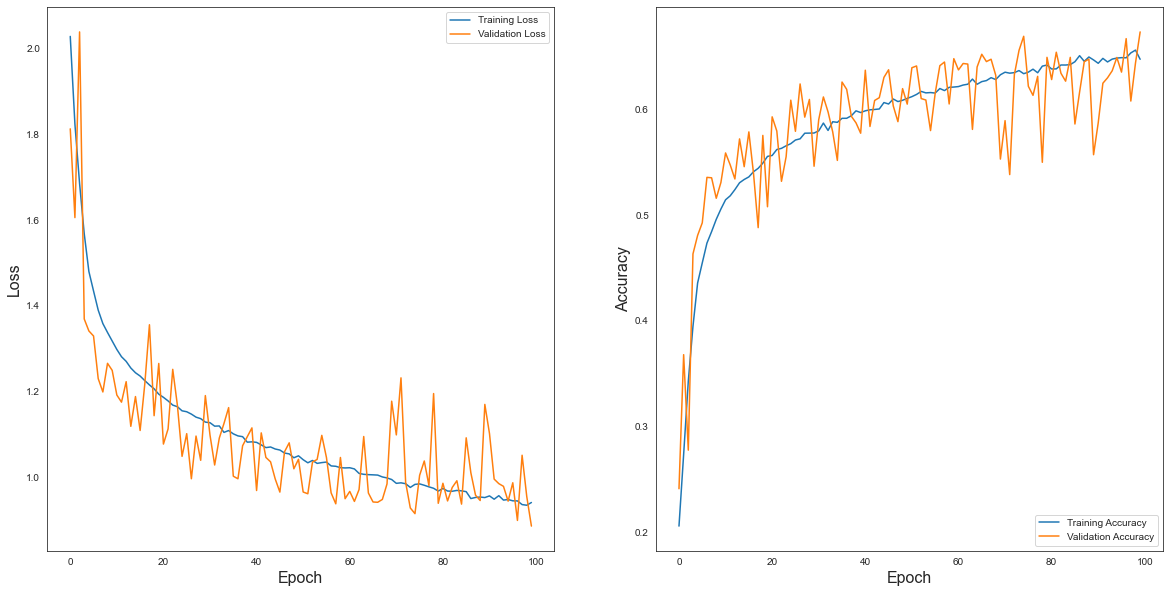

In [ ]:
# plotting the Loss for training and validation set
sns.set_style("white")
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# plotting the Accuracy for training and validation set
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#MODEL ACCURACY
print(max(history.history['val_accuracy']))

0.6733959913253784


Our model have been trained, now we will use it to make predictions on our test data.
The test dataset consists of 1 photo for each emotion class.

# **MODEL TESTING**

We will now test our model. I have used 1 image per emotion class from a different dataset for this purpose.

In [ ]:
#Prediction on test data
pred = model.predict(test_data)

#predicted emotion
predicted_class_indices=np.argmax(pred,axis=1)

#getting label of prediction
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#putting final result in a dataframe
result2 = pd.DataFrame({"Emotions":labels.values(),
                      "Predictions":predictions})

In [ ]:
#print the predictions
results2

,Emotions,Predictions
0,angry,angry
1,disgust,surprise
2,fear,fear
3,happy,happy
4,neutral,neutral
5,sad,sad
6,surprise,angry


Wohoo!!!
5 out of 7 predictions are correct. Our model is doing really well considering limited computational power.

# CONCLUSION


1. Our model has been trained with about 68% accuracy on validation set.
2. 5 out of 7 emotions have been predicted correctly on test set.
3. A better accuracy can be achieved with more computational power.
